# Защита проекта по направлению машинного обучения.
- В данном файле представлено описание проделанной работы. Полностью описать все не получится, поэтому здесь присутсвуют ссылки на файлы [проекта из GitHub](https://github.com/GrishaTS/YaMlProject/). GitHub не всегда отрисовывает картинки при просмотре файлов на сайте, поэтому советую скачать проект.
## Задача проекта:
Представлен датасет из 10 классов (10 цифр) - [SVHN](http://ufldl.stanford.edu/housenumbers/) (The Street View House Numbers). Задачей проекта является классификация цифр, находящихся посередине изображения.

Импорт необходимых библиотек.

In [9]:
import math
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
from PIL import Image
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

----
----
# 1. Предобработка данных и работа с датасетом.

Скачиваем датасет для визуализации данных.

In [2]:
protect_ds = pickle.load(open('protect_ds', 'rb'))
protect_ds_x = protect_ds['images']
protect_ds_y = protect_ds['labels']

Изобразим данные без обработки.

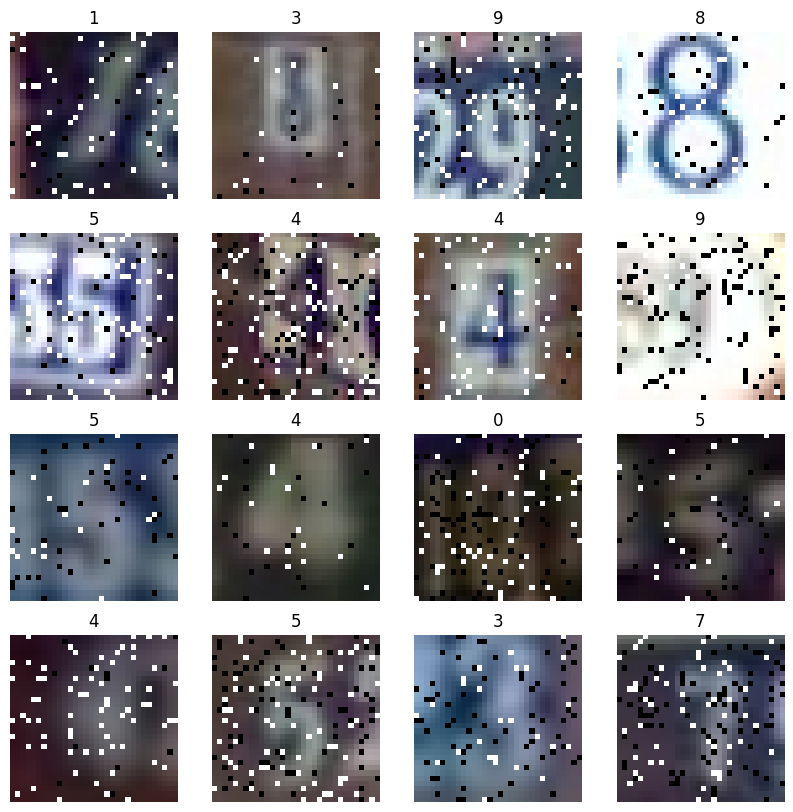

In [3]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(protect_ds_x[i] / 255, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

Изобразим балансировку классов.

Text(0.5, 1.0, 'Class balance')

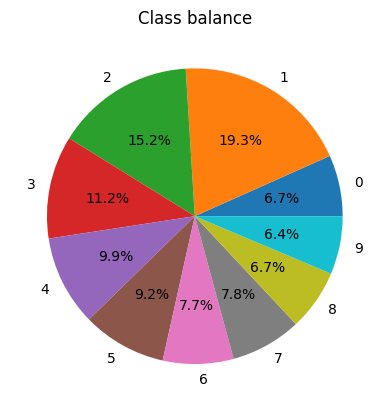

In [27]:
plt.pie([3341, 9650, 7595, 5625, 4941, 4604, 3859, 3876, 3332, 3177], labels=range(10), autopct='%.1f%%')
plt.title('Class balance')

- О датасете можно сказать следущие вещи:
    - В датасете на изображении бывают сразу несколько цифр, однако распозновать надо только то, что находится посередине.
    - В данных присутсвуют битые пиксели.
    - Есть выбросы (картинку снизу слева распознать человеку просто невозможно).
    - Датасет имеет дисбаланс классов.

----
## 1.1 Битые пиксели.
В представленном датасете битые пиксели либо абсолютно чёрные, либо абсолютно белые. Очевидно их наличие значительно осложняет обучении модели и с ними необходимо бороться.

Также стоит отметить низкое качество изображений из датасета, что наводит на мысли о максимальной минимализации потерь при обработке - при работе с битыми пикселями нужно сохранить максимальное количество исходных данных.

Исходя из этих умозаключений отметаются сложные варианты удаления шума, более эффективные на больших изображениях, но потенциально способные сильно исказить данные на малом объёме. 

Нужен простой и эффективный метод, который будет с минимальными потерями восстанавливать изображение.


- Теоритическое обоснование разработанного метода:
    - Нужно стремиться к минимальному искажению изображения, поэтому работать мы будем только с битыми пикселями, идентифицируя их по абсолютным значениям (255, 255, 255), (0, 0, 0).
    - После детекции битого пикселя, мы присваиваем ему среднее значение среди восьми соседних пикселей. Однако если соседений пиксель тоже битый, то он не учитывается при подсчете среднего.

In [4]:
def is_broken_pixel(rgb_color):
    return np.array_equal(rgb_color, [1., 1., 1.]) or np.array_equal(rgb_color, [0., 0., 0.])


def get_average_pixel(image, i, j):
    pixels_bunch = image[i - 1:i + 2, j - 1:j + 2, :]
    good_pixels_summ = np.zeros(3)
    good_pixels_count = 0
    for i in range(len(pixels_bunch)):
        for j in range(len(pixels_bunch)):
            if not is_broken_pixel(pixels_bunch[i, j]):
                good_pixels_summ += pixels_bunch[i, j]
                good_pixels_count += 1
    if good_pixels_count == 0:
        return good_pixels_summ
    return good_pixels_summ / good_pixels_count


def repair_image(image):
    padding_image = np.full((len(image[0]) + 2, len(image[0]) + 2, 3), 0.)
    padding_image[:, :, 0] = np.pad(image[:, :, 0], pad_width=1, constant_values=0.)
    padding_image[:, :, 1] = np.pad(image[:, :, 1], pad_width=1, constant_values=0.)
    padding_image[:, :, 2] = np.pad(image[:, :, 2], pad_width=1, constant_values=0.)
    for i in range(1, len(padding_image) - 1):
        for j in range(1, len(padding_image) - 1):
            if is_broken_pixel(padding_image[i, j]):
                padding_image[i, j] = get_average_pixel(padding_image, i, j)
    return padding_image[1: -1, 1: -1, :]

Изобразим те же изображения, что мы показывали вначале, но уже после обработки битых пикселей.

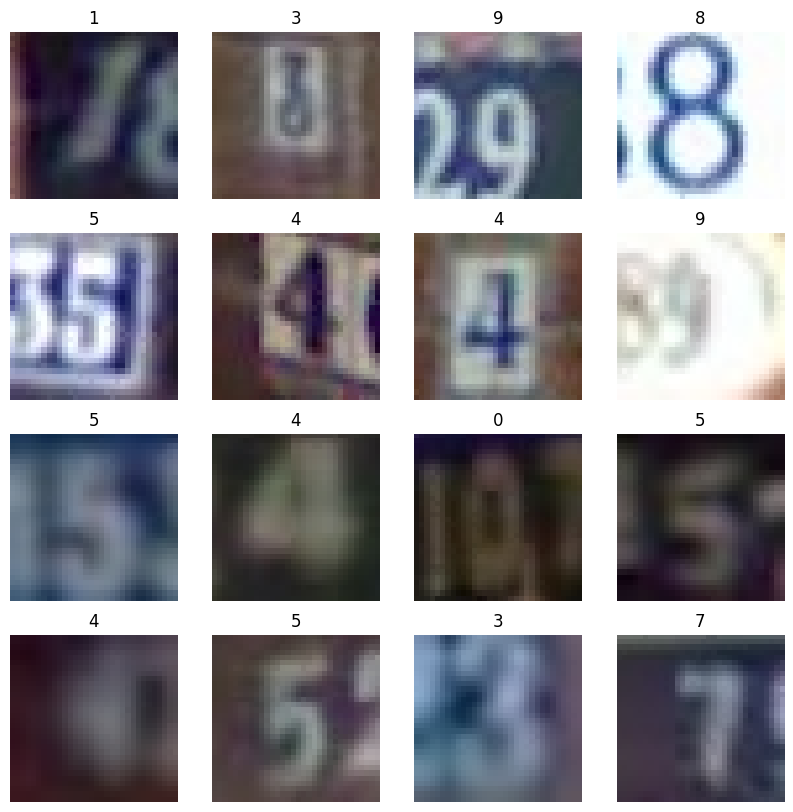

In [5]:
plt.figure(figsize=(10, 10))
for i in range(16):
    protect_ds_x[i] = repair_image(protect_ds_x[i] / 255) * 255
    plt.subplot(4, 4, i + 1)
    plt.imshow(protect_ds_x[i] / 255, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

----
## 1.2 Аугментация.
- Это методика создания дополнительных обучающих данных из уже имеющихся.
### 1.2.1 Теория.
#### С какими проблемами помогает справиться аугментация?
- Помогает бороться с переобучением, потому что модель не будет получить одну картинку несколько раз.
- Видоизменяя изображение, аугментация готовит модель к `суровым` реальным данным.
### 1.2.2 Практика.
- При выборе агументации мы столкнулись с проблемой скудного выбора, предоставленного tensorflow для данной подхода обработки датасета.
- Мы остановились на torchvision, которые предоставляет большое разнообразие вариантов аугментации.
- Мы рассмотрели все варианты аугментации, которые предоставляет torchvision, выделили все потенциально хоршие, сделали всевозможные комбинации из них и прогнали модель на каждой комбинации. Очень советую ознакомиться с файлами [augmentation.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/Augmentation/augmentation.ipynb) и [aug_models.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/Augmentation/aug_models.ipynb).
- По итогу у нас вышло несколько лидирующих комбинаций, лучшая из которых представлена ниже:

In [6]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4)
])

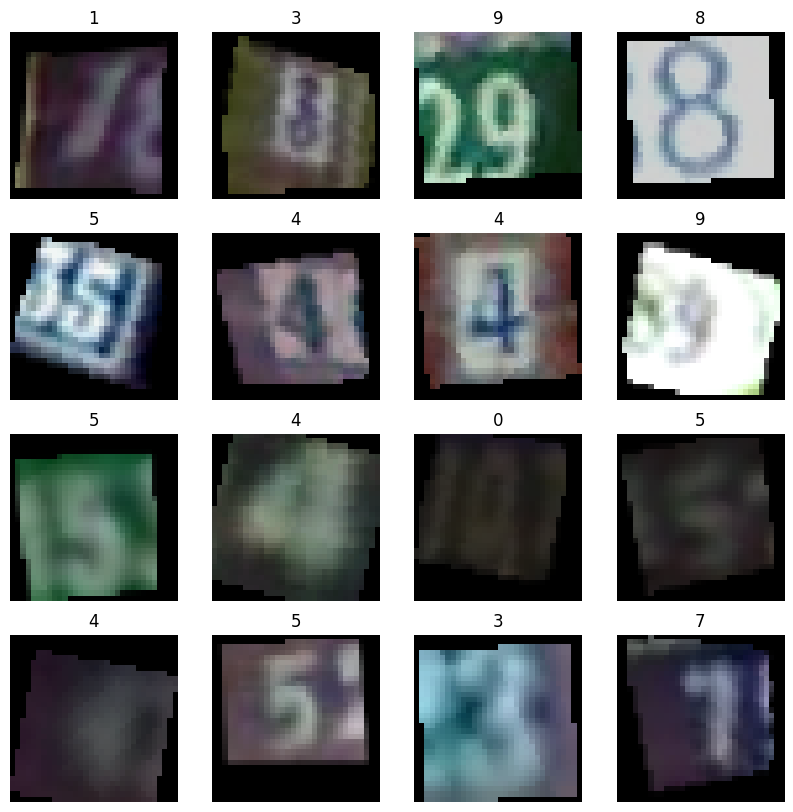

In [14]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = np.array(transformer(Image.fromarray(np.uint8(protect_ds_x[i]), 'RGB')))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

----
## 1.3 Работа с датасетом.

Код для работы с датасетом мы вынесли в файл [datasets.py](https://github.com/GrishaTS/YaMlProject/blob/main/core/datasets.py).

Советую ознакомиться с файлом [ds.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Liza/ds.ipynb)

In [10]:
class DataSequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, transform=None, batch_size=512):
        self.x = x_set
        self.y = y_set
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        shuffle = np.random.permutation(batch_x.shape[0])
        batch_x, batch_y = batch_x[shuffle], batch_y[shuffle]
        if 'torchvision.transforms' in str(type(self.transform)):
            return (
                np.array([np.asarray(self.transform(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
                batch_y
            )
        return batch_x / 255, batch_y

In [12]:
train_ds = DataSequence(protect_ds_x, protect_ds_y, transformer, batch_size=3)

In [13]:
train_ds[0]

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

----
## 1.4 Дисбаланс классов.
- Такая проблема возникает, когда количество выборок между разными классами несбалансировано, и результирующая модель ML будет смещена в сторону одного или нескольких классов с частыми выборками по сравнению с другими классами с нечастыми выборками.
### 1.4.1 OverSampling
- Уменьшение кол-ва изображений. 
### 1.4.2 UnderSampling
- увеличение кол-ва изображений(в нашем случае, на основе уже имеющихся).

 Мы пытались найти идельное кол-во экземпляров для каждого класса. 
- 4 варианта датасета:
    1. с дисбалансом классов.
    2. В каждом классе 5000 изображений.
    3. В каждом классе 7000 изображений.
    4. В каждом классе 9650 изображений.

Лучше всего себя показал датасет номер 3 (7000). Подробнее про OverSampling и о практике применения датасетов можно прочитать в файле [class_balance.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/class_balance.ipynb)

----
----
# 2. Модели.
Нацонец-то мы переходим к основной части проекта. Далее мы рассмотрим архитектуры и подходы, которые не только показали хорошие метрики, но и привели нас к правильным выводам о необходимости использования того или иного метода.

----
## 2.1 Чекпоинты.
- Чтобы не обучать модель по два раза: обучение модели на большом кол-ве эпох (для того чтобы определить на какой эпохе начинается переобучение), обучение модели до переобучения; Tensorflow предоставляет возможность сохранять модель во время обучения на определенных эпохах.

### 2.1.1 Для этого мы должны скомпилировать модель с метриками, которые мы будем отслеживать.
```python
model.compile(
    optimizer=optimizer,
    metrics=['categorical_accuracy', tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')],
    loss=loss,
)
```
##### Мы указали такие метрики как `accuracy` и `f1_score`
##### $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
##### $F\_score = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$
### 2.1.2 Далее мы должны добавить в `callbacks` необходимые чекпоинты.
#### 2.1.2.1 Классические чекпоинты.
Сохранение модели на эпохе с самым большим `accuracy`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_categorical_accuracy.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
)
``` 
Сохранение модели на эпохе с самым маленьким `loss`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
```
Сохранение модели на эпохе с самым большим `f1_score`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_f1_score.h5',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
)
```

#### 2.1.2.1 Усредненные чекпоинты.
- TendorFlow Addons предоставляет функционал сохранения чекпоинта по усредненным весам. То есть чекпоинт выделяет несколько лучших эпох и усредняет веса между ними. Таким образом, мы делаем собирательный образ лучших эпох модели, что сильно помогает обобщить распознование классов.

Сохранение модели по максимальному скользящеему среднему `accuracy`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_categorical_accuracy.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
)
```
Сохранение модели по минимальному скользящеему среднему `loss`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
```
Сохранение модели по максимальному скользящеему среднему `f1_score`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_f1_score.h5',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
)
```

- #### Таким образом, мы получаем практически лучшие веса для модели. Еще плюсом является то, что, написав одну модель, мы имеем 6 чекпоинтов, которые можно отправить на kaggle и выявить лучший.
- Все чекпоинты мы сохраняли в папку [checkpoints](https://github.com/GrishaTS/YaMlProject/tree/main/models/checkpoints), для дальнейшего улучшения модели или ансамблирования.
### Как показала практика, лучшими чекпоинтами являются скользящее среднее по `accuracy` и скользящее среднее по `f1_score`

----
## 2.2 Оптимизаторы.

----
## 2.3 Архитектуры.
### 2.3.1 Исследование.
- Перед написанием архитектур, мы изучили важные слои cv-нейросетей для полного понимания как все это работает.
- Повторюсь, что в этом файле мы делаем краткий пересказ, поэтому в загаловки следующих пунктов мы вставили ссылки на гит файлы, в которых есть и полная теория, и применения на практике.
#### 2.3.1.1 [Convolution](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/ConvAndPool/conv_pool.ipynb)
- Сперва мы определили, какая из перечисленных (1D vs 2D vs 3D) сверток подходит больше всего.

Одной из задач свертки является показать зависимость соседних клеток, которые и формируют картинку. 1D Convolution не подойдет, потому что такой вариант свертки покажет зависимость соседних пикселей только в одной оси. 3D Convolution не уместен для данного датасета, потому что у нас изображения размером (32, 32, 3). 2D Convolution лучше всего подходит для классификации rgb изображений.
### Потом мы приступили к типам сверток (Здесь разберем только интересные):
### - Depthwise Convolution

[tf.keras.layers.DepthwiseConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)

Плюсы:
- Уменьшаем кол-во вычеслений (сильно)
- Хорошо показываем зависимость соседних пикселей

Минусы:
- Мы не учитываем зависимость между слоями

![-](https://animatedai.github.io/media/depthwise-convolution-animation-3x3-kernel.gif)

Такой вариант свертки использовался в нашей лучшей модели.
### Separable Convolution
[tf.keras.layers.SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D)
Плюсы:
- Уменьшаем кол-во вычеслений (примерно в 9 раз!!!)
- Хорошо показываем зависимость соседних пикселей
- Мы учитываем зависимость между слоями

Минусы:
- Не заметил

![-](https://animatedai.github.io/media/depthwise-separable-convolution-animation-3x3-kernel.gif)

Очень интересный вариант свертки, который хорошо показывал себя в большинстве случае, однако в лучших моделях не оказался.

#### 2.3.1.2 [Pooling](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/ConvAndPool/conv_pool.ipynb)
- В данном пункте мы узучили 4 вида пулингов:
    - AveragePooling2D
    - MaxPool2D
    - GlobalAveragePooling2D
    - GlobalMaxPool2D

Однако сказать какой может быть лучше нельзя. Для данного датасета, взависимости от архитектуры, каждый из вариантов пулинга может раскрыться по-разному. Поэтому в моделях мы использовали все типы пулингов.
#### 2.3.1.3 [Skip-Connection](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/SkipConnection/skip_conection.ipynb)
##### Проблемы с которыми борется skip-connection:
- Когда архитектуры моделей стали очень большими, то появилась проблема, названная затухающим градиентом. Skip-Connections смягчают проблему исчезновения градиента, позволяя этому альтернативному короткому пути проходить градиент.
- Когда мы производим различные действия над изображением (такие как свертка или pooling), то появляется возможность потерять фичи изображения, поэтому skip-connection также называют остаточным изображением.
- В данном пункте мы узучили все варианты skip-connections, предоставляеммые tensorflow.
- Как и в теории, так и на практике мы пришли к одному мнению: Для данного датасета самыми подходящими вариантами Skip-Connection являются
    - `tf.keras.layers.Concatenate`. На вход принимает список слоёв с одинаковым shape, кроме одного(будет указан в axis). Возвращает объединённый tensor, состоящий из входных слоёв. Помогает вообще не терять фичи, а просто переносит их с одного места на другое. 
    - `tf.keras.layers.Add`. Принимает слои с идентичной формой и возвращает поэлементную **сумму** значений нейронов на соответствующих местах

##### Skip-Connection присутсвует в каждой нашей лучшей модели.
### 2.3.2 Архитектуры наших нейросетей.
Переходим к самом интересному. Мы рассмотрели около 25 архитектур, среди которых есть как наши, так и те, что были написаны для ImageNet. Здесь мы рассмотрим 5 архитектур.
#### 2.3.2.1 GoogLeNet
[Модель 11](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_11.ipynb)

[Модель 17](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_17.ipynb)

[Модель 22](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_22.ipynb)

<img src="data/GoogLeNet.png" width="729"/>

На рисунке изображена схема локализованной под наш датасет гуглнет подобной модели. Такая архитектура показала очень хорошие метрики. Главной характерной оссобеностью данной модели является Inception блок. Идея таких блоков такова: мы не знаем какого размера свертку лучше всего применить на слое i, поэтому применяем сразу несколько сверток разного размера, объединяя их потом skip-connection-ом, таким образом каждая свертка выделяет разные фичи.

#### 2.3.2.2 SqueezeNet
[Модель 5](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_5.ipynb)

[Модель 6](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_6.ipynb)

[Модель 14](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_14.ipynb)

[Модель 15](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_15.ipynb)

<img src="data/SqueezeNet.png" width="200" />

Эта модель получилась не очень удачной. Сперва нам показалось, что данная модель слишком глубокая, что может вызывать проблему взрывного градиента (модель 5 и 6). Однако уменьшив кол-во squeeze блоков, ничего не поменялось. Я думаю, что данная модель предполагает другой датасет (в котором кол-во фичей будет больше) и глубокую архитектуру.


#### 2.3.2.3 DenceNet
[Модель 7](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_7.ipynb)

[Модель 16](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_16.ipynb)

<img src="data/DenceNet.png" width="200" />

Данная модель подавала большие надежды - она показывала неплохие метрики на тестовом датасета, однако по итогу не вошла в финальный ансамбль. Мне кажется, что такие плотные Dence блоки не должны быть в таком малом кол-ве (2 или 3), однако наш датасет крайне мал, как и кол-вом фичей в классах, так и кол-вом самих классов.

#### 2.3.2.4 Модель 20
[Модель 1](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_1.ipynb)

[Модель 20](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_20.ipynb)

<img src="data/m20.png" width="200" />

Это тоже неплохая модель, она написана классическим паттерном (как vgg). То есть мы только сжимаем изображение polling-ом или stride-ом, но увеличиваем кол-во фильтров в свертке. Мы писали несколько таких моделей, но у нас никак не получилось реализовать их хорошо (хотя явно можно было бы прийти к хорошим метрикам с такой архитектурой)

# 3. Ансамбли
это ывалаотьфылвоаыфваос фывоа длфывоадфы вождлфыв

общая теория
## 3.1 Типы ансамблей
## 3.1.1 Беггинг
это аоллдыфвоафж

теория (можно сказать про то что должны быть разные архитектуры) ВОТ ПРЯМ ВСЕ ЧТО ТЫ ЗНАЕШЬ

потом наш код, описание кода для беггинга

потом рассказывавешь про практику применения

рассказываешь какие закономерности нашли и может быть комбинации

## 3.1.2 Бустинг 

это аоллдыфвоафж

теория (можно сказать про то что должны быть разные архитектуры) ВОТ ПРЯМ ВСЕ ЧТО ТЫ ЗНАЕШЬ
